In [4]:
%matplotlib inline


import pydicom as dicom
import matplotlib.pylab as plt

import os
import numpy as np

In [5]:
def load_CT(PATH):
    slices = [dicom.dcmread(PATH + '/' + s) for s in os.listdir(PATH)]
    return slices
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [6]:
FOLDER_PATH = "E:/Egyetem/AI/_Orvosi képfeldolgozás/Datasets/positive_lung_CT/tudodaganat/"
featured_cmaps = ["bone","hot","twilight","PuBuGn","inferno","seismic","hsv","twilight_shifted","spring","Accent","bwr","afmhot"  ]

In [7]:
CT_dicom = load_CT(FOLDER_PATH)
CT_kepsorozat = get_pixels_hu(CT_dicom)

In [8]:
def print_CT_layers(first,last,dataset,CMAP):
    for i in range(first,last):     
        plt.imshow(dataset[i],cmap=CMAP)
        plt.title(str(i)+". picture with cmap:"+CMAP)
        plt.show()
       # plt.close(fig)

In [9]:
def print_CT_layers_in_table(first,last,dataset,CMAP):
    rows=1 
    columns = 4
    #fig, ax_lst = plt.subplots(2, 2, figsize=(12,8))
    fig = plt.figure(figsize=(30, 30))    
    for i in range(first,last):    
        if((i-first)%4 ==0):
            rows=rows+1;
            fig = plt.figure(figsize=(30, 30))
        fig.add_subplot(1,columns, ((i-first)%4)+1)
        plt.axis('off')
        plt.imshow(dataset[i],cmap=CMAP)
        plt.title(str(i)+".")
    plt.show()
     

In [10]:
#segmentation:
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
import cv2
import scipy


def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
def segment_lung_mask(image, fill_lung_structures=True):
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image >= -700, dtype=np.int8)+1
    labels = measure.label(binary_image)
    background_label = labels[0,0,0]
 
    # Fill the air around the person
    binary_image[background_label == labels] = 2
 
    # Method of filling the lung structures (that is superior to 
    # something like morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
 
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
 
    # Remove other air pockets inside body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

def total_lung_MASK(img):
    return 1-scipy.ndimage.filters.gaussian_filter(1-img, 0.7, order=0, output=None, mode='reflect', cval=0.7, truncate=7.0)

    

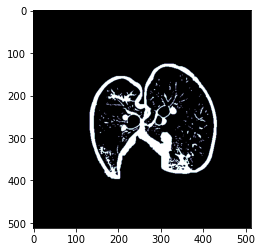

In [11]:
# get masks 
import copy

segmented_lungs = segment_lung_mask(CT_kepsorozat, fill_lung_structures=False)
segmented_lungs_fill = segment_lung_mask(CT_kepsorozat, fill_lung_structures=True)
internal_structures = segmented_lungs_fill - segmented_lungs
#own internal structures:
lung_mask = total_lung_MASK(segmented_lungs_fill)
own_internal_structures = lung_mask-segmented_lungs
# isolate lung from chest
copied_pixels = copy.deepcopy(CT_kepsorozat)
for i, mask in enumerate(segmented_lungs_fill): 
    get_high_vals = mask == 0
    copied_pixels[i][get_high_vals] = 0
seg_lung_pixels = copied_pixels
# sanity check
plt.imshow(own_internal_structures[169], cmap=plt.cm.bone)

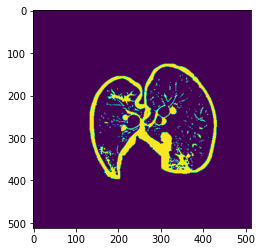

In [12]:
plt.imshow(own_internal_structures[169])

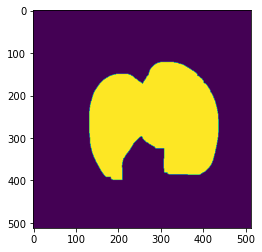

In [36]:
def total_lung_MASK3(img):
    return 1-scipy.ndimage.filters.gaussian_filter(1-img, 1.6, order=0, output=None, mode='reflect', cval=0.7, truncate=7.0)

ttll = total_lung_MASK3(segmented_lungs_fill[169])
plt.imshow(ttll)

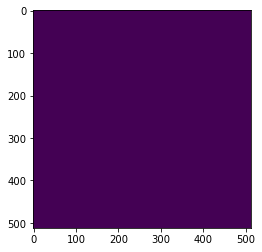

In [65]:
def total_lung_MASK2(img):
    return 1-scipy.ndimage.filters.gaussian_filter(1-img, 0.9, order=0, output=None, cval=0.9, truncate=0.9)

ttl = total_lung_MASK2(segmented_lungs_fill[169])
plt.imshow(ttl)

In [15]:
#todo
def print_CT_layers_segmented(first,last,dataset,CMAP, full_CT=True):
    rows=1 
    columns = 4
    #fig, ax_lst = plt.subplots(2, 2, figsize=(12,8))
    fig = plt.figure(figsize=(30, 30))    
    for i in range(first,last):    
        if((i-first)%4 ==0):
            rows=rows+1;
            fig = plt.figure(figsize=(30, 30))
        fig.add_subplot(1,columns, ((i-first)%4)+1)
        plt.axis('off')
        if(full_CT):
            dts = np.ma.masked_where(dataset[i] <0.1 , segmented_lungs[i])
            plt.imshow(CT_kepsorozat[i], cmap=plt.cm.bone, alpha=0.8)
            plt.imshow(dts, cmap=CMAP, interpolation='none')
        else:
            plt.imshow(dataset[i], cmap=CMAP, interpolation='none')
        plt.title(str(i)+".")
    plt.show()

<Figure size 2160x2160 with 0 Axes>

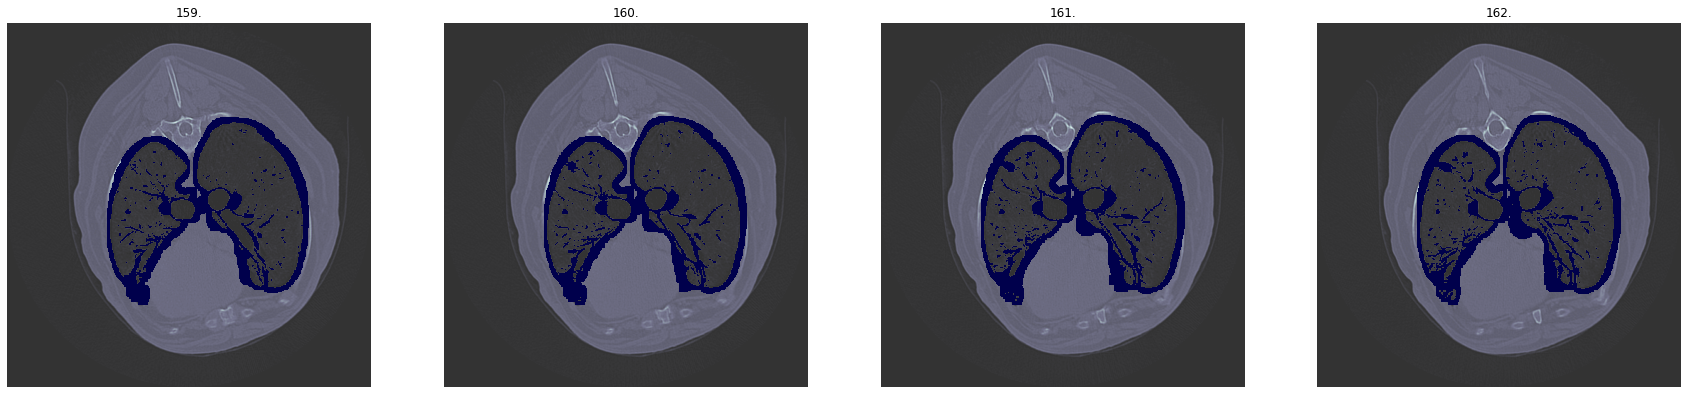

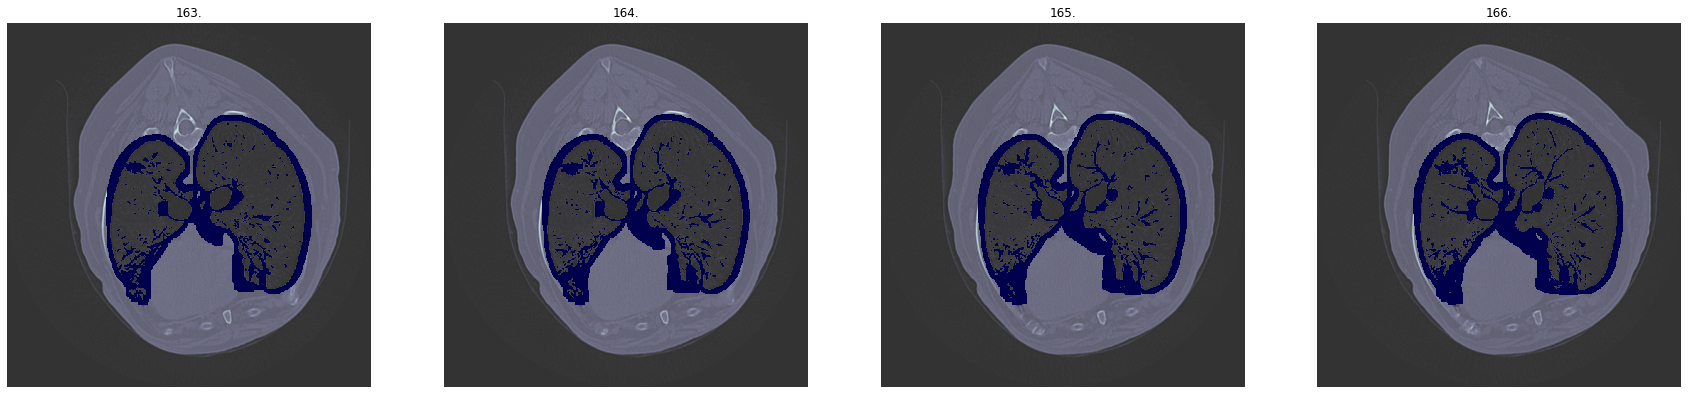

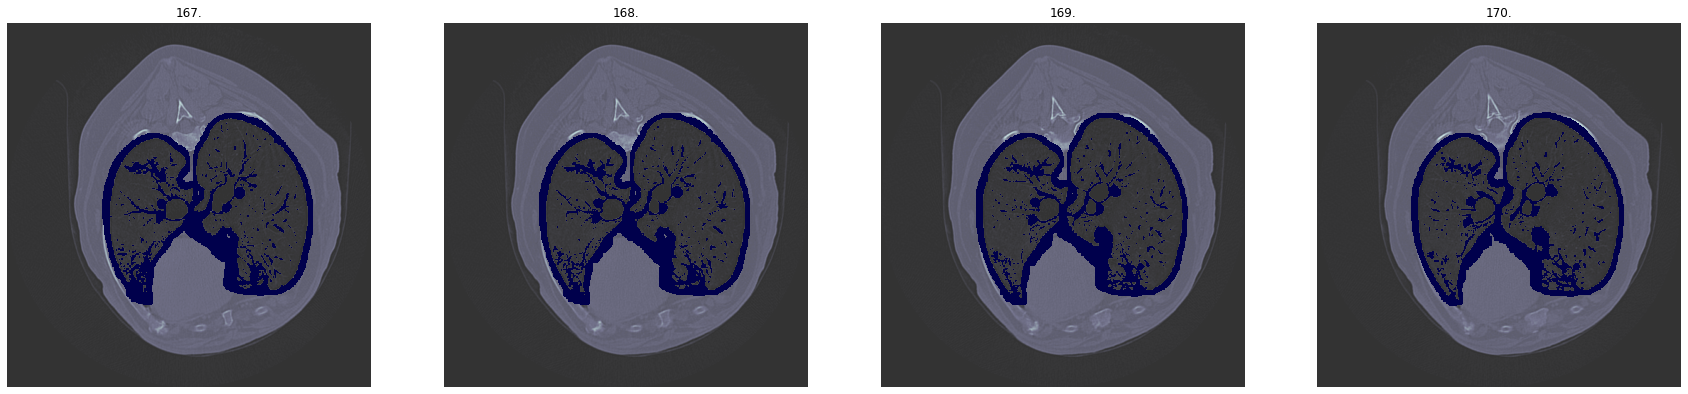

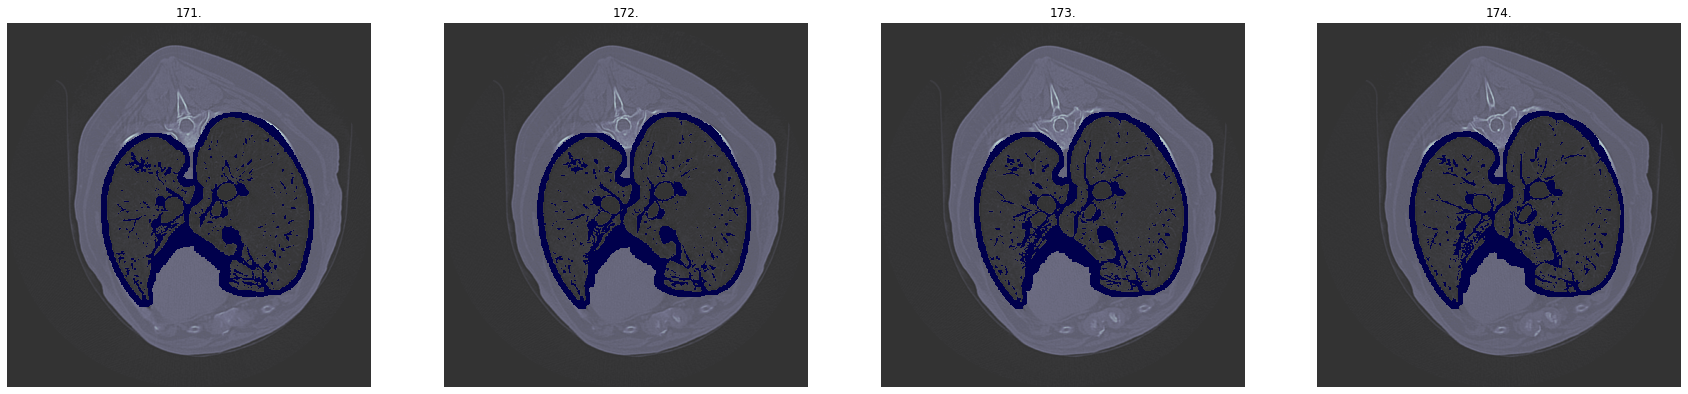

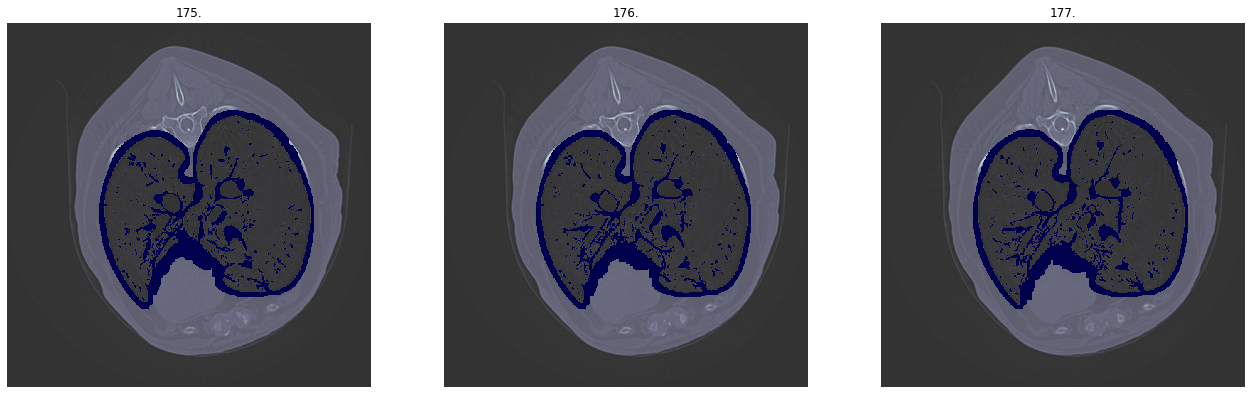

In [16]:
print_CT_layers_segmented(159,178,own_internal_structures,featured_cmaps[5], True)

<Figure size 2160x2160 with 0 Axes>

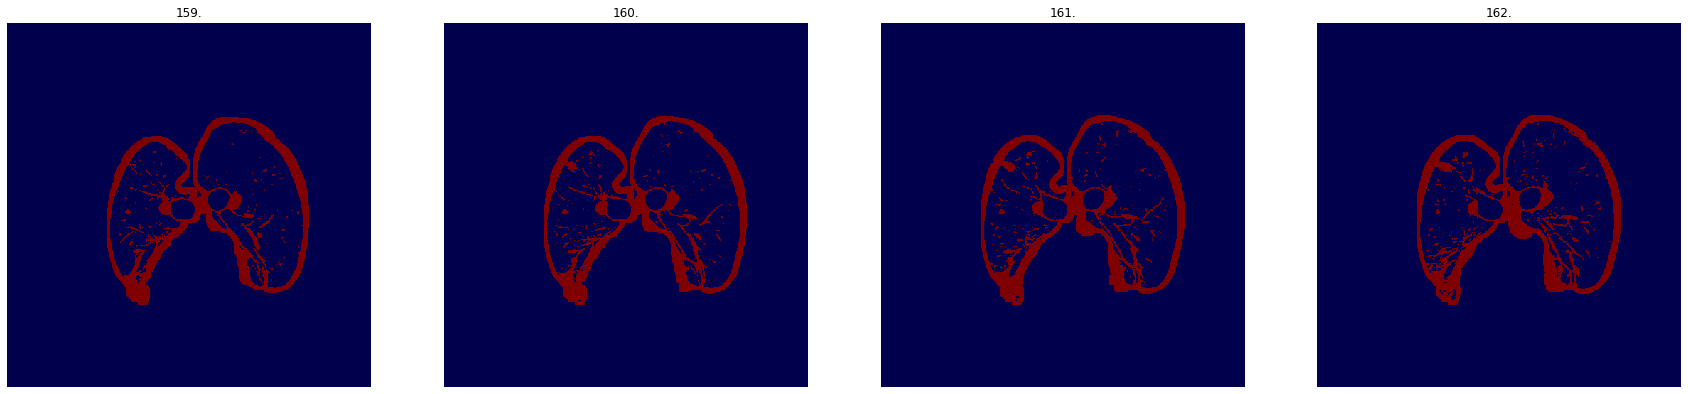

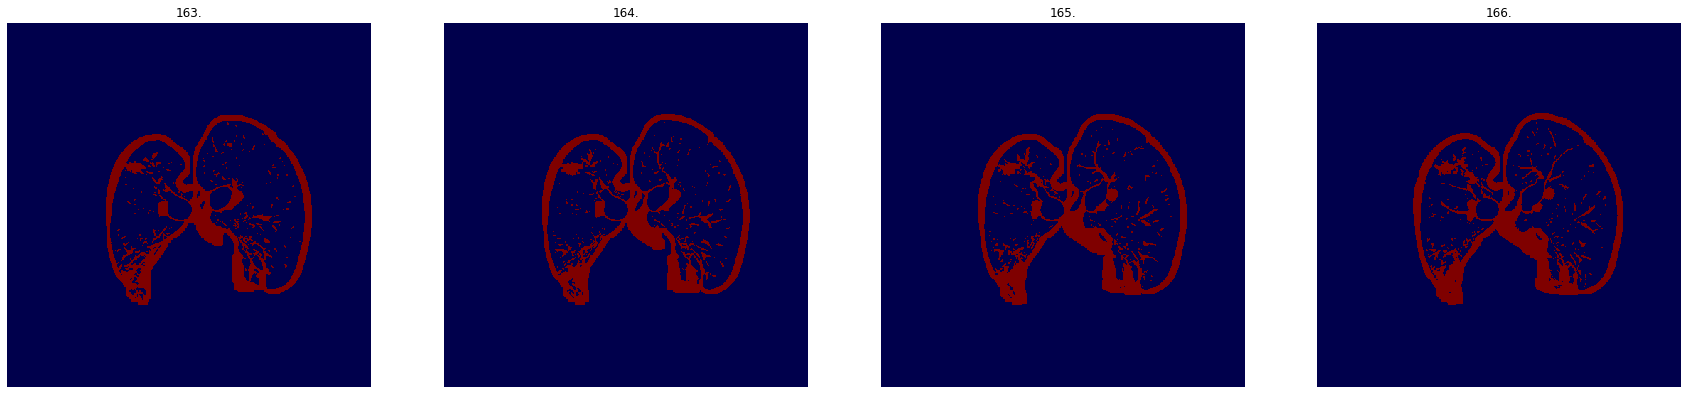

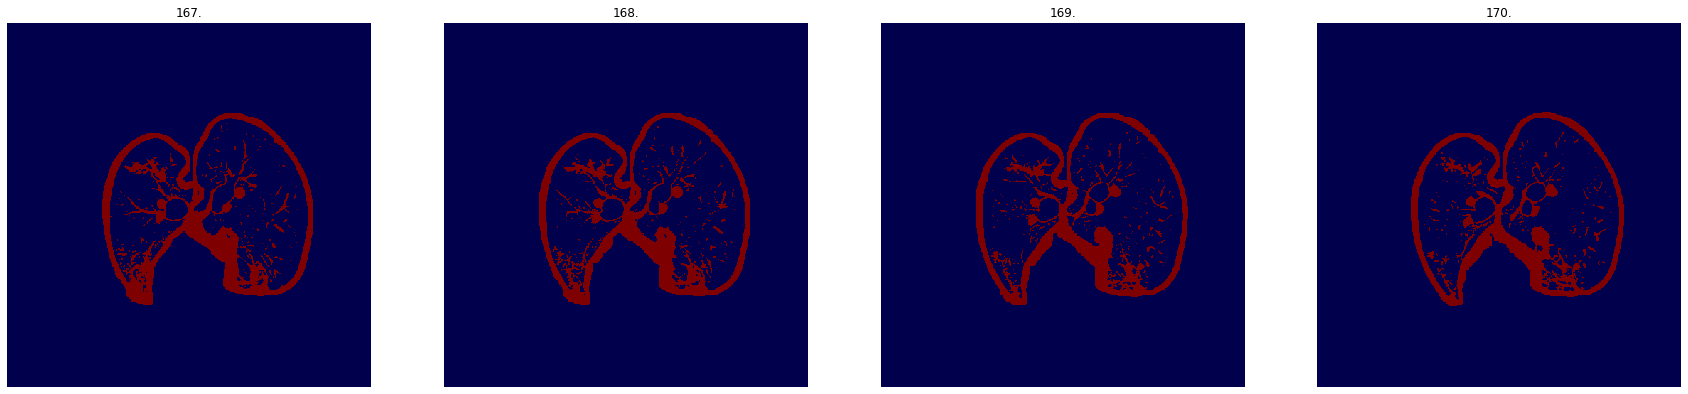

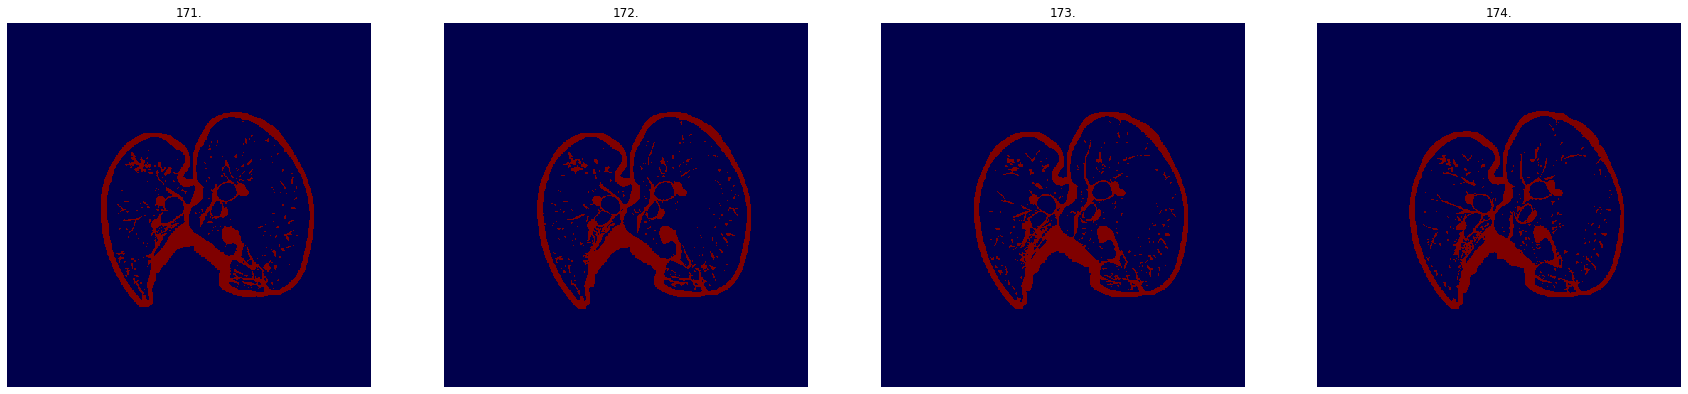

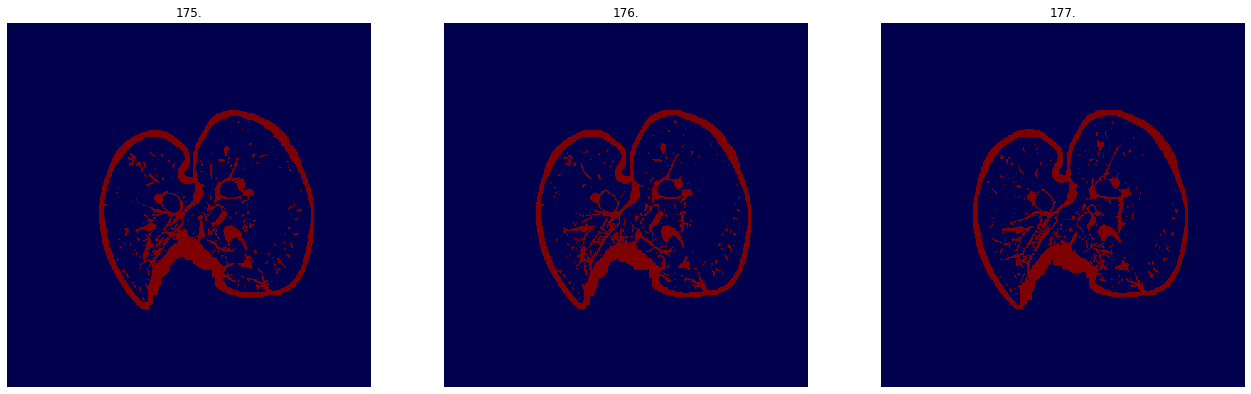

In [43]:
print_CT_layers_segmented(159,178,own_internal_structures,featured_cmaps[5], False)

<Figure size 2160x2160 with 0 Axes>

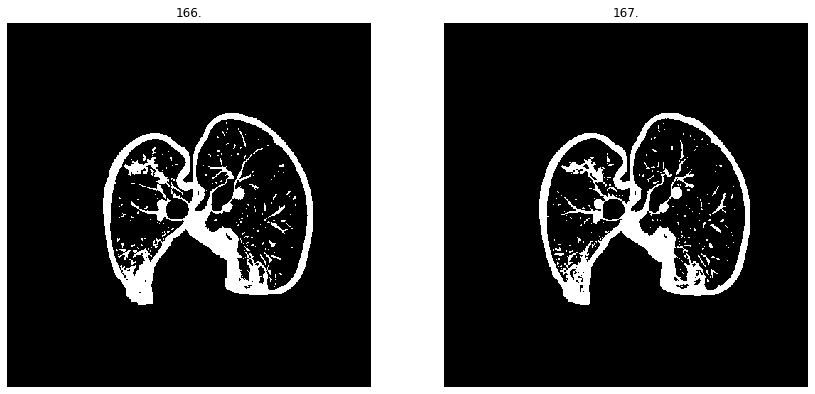

<Figure size 2160x2160 with 0 Axes>

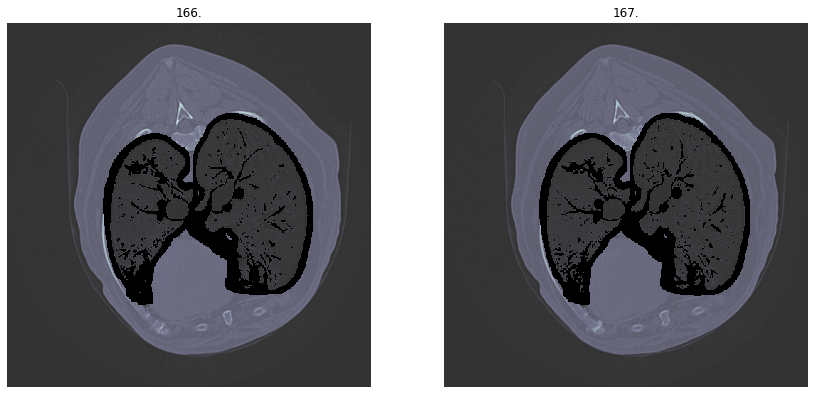

<Figure size 2160x2160 with 0 Axes>

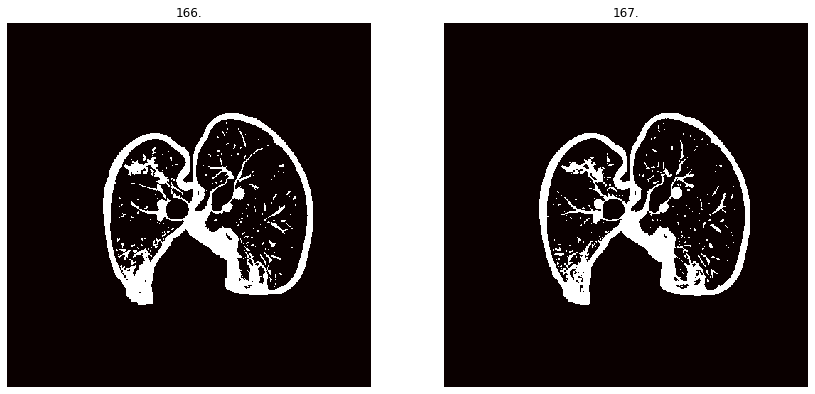

<Figure size 2160x2160 with 0 Axes>

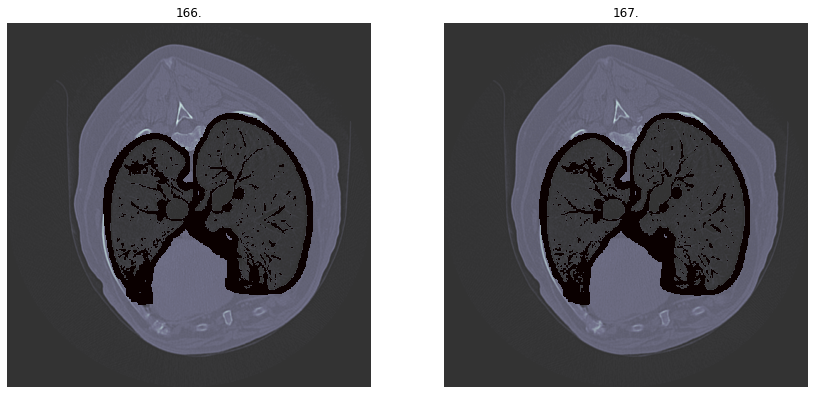

<Figure size 2160x2160 with 0 Axes>

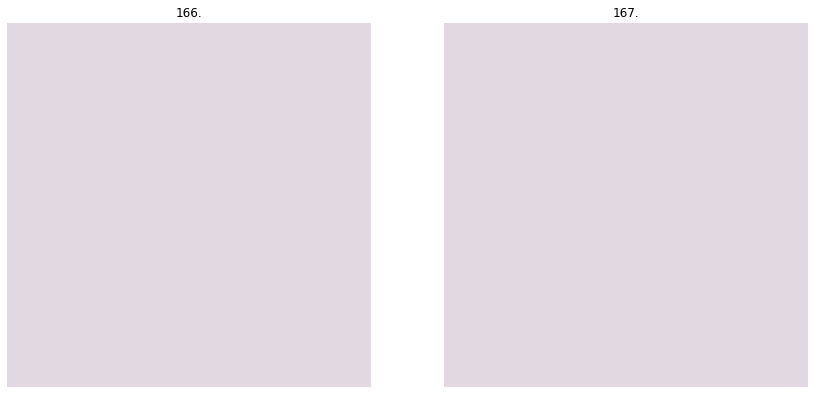

<Figure size 2160x2160 with 0 Axes>

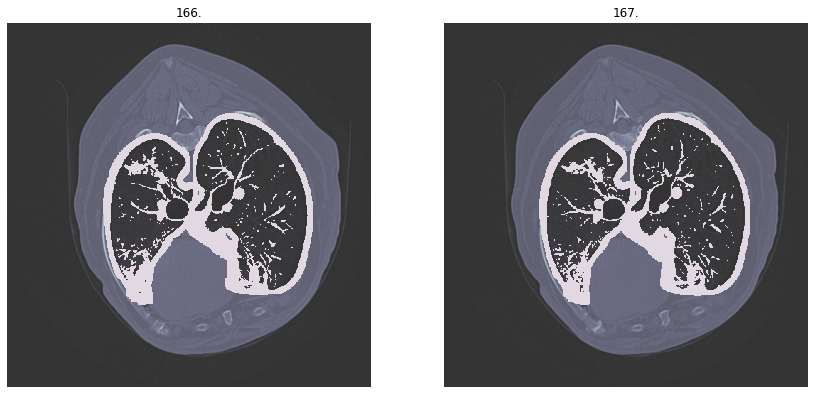

<Figure size 2160x2160 with 0 Axes>

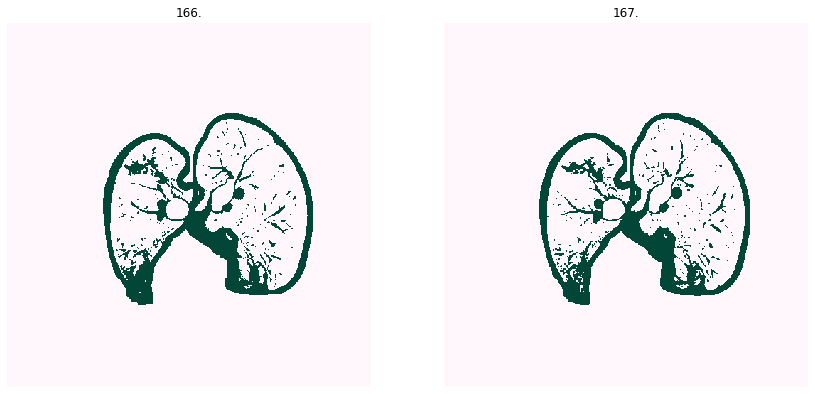

<Figure size 2160x2160 with 0 Axes>

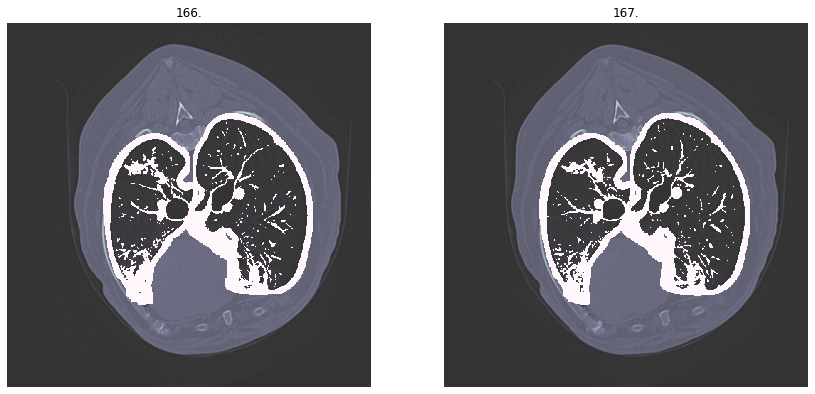

<Figure size 2160x2160 with 0 Axes>

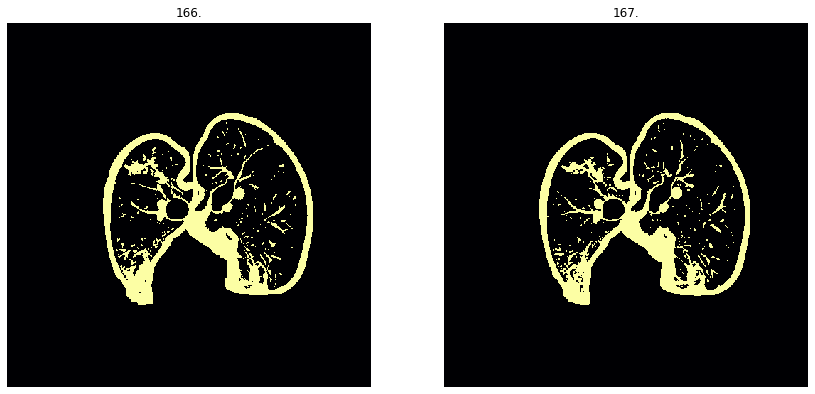

<Figure size 2160x2160 with 0 Axes>

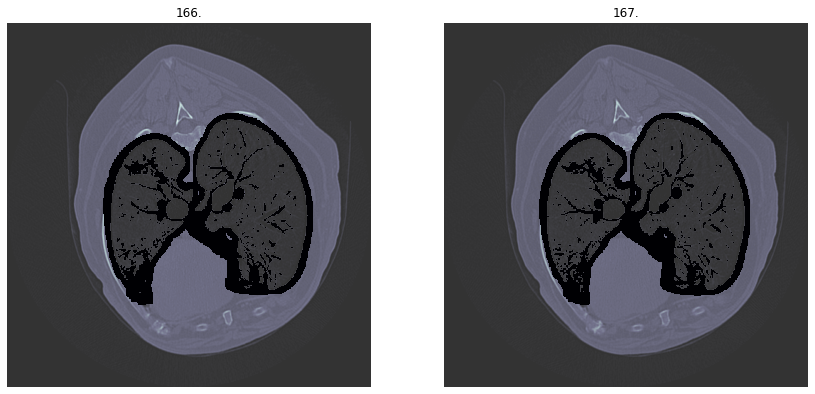

<Figure size 2160x2160 with 0 Axes>

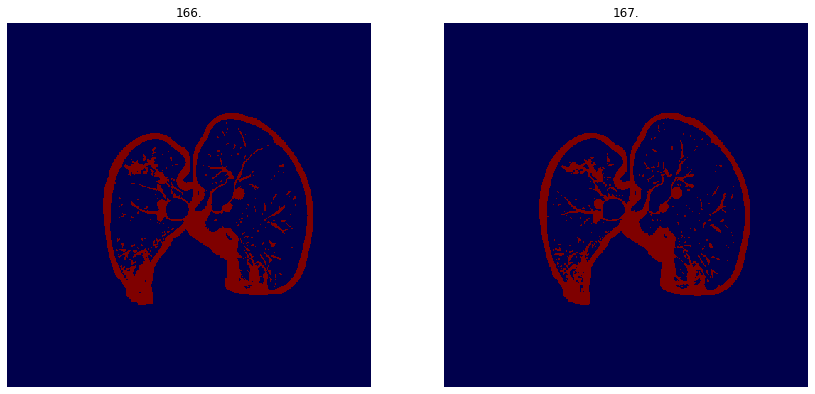

<Figure size 2160x2160 with 0 Axes>

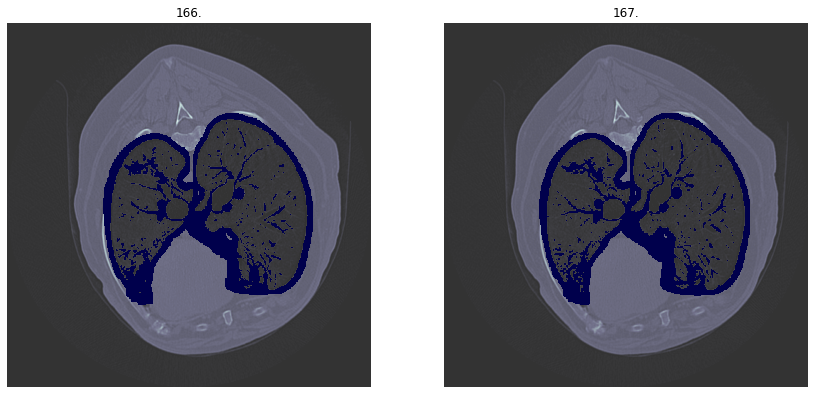

<Figure size 2160x2160 with 0 Axes>

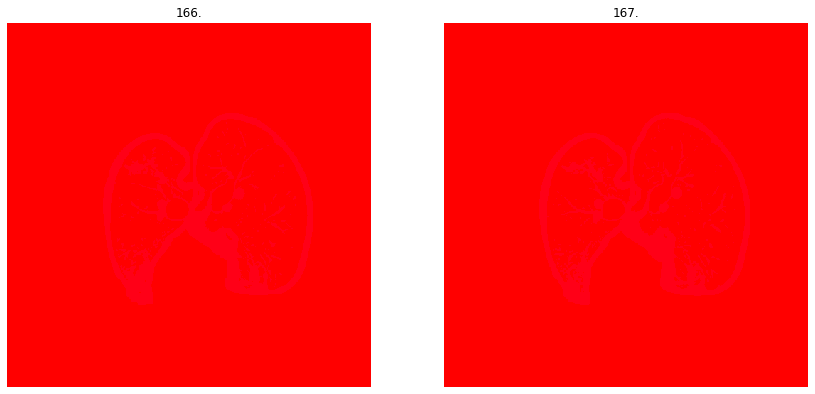

<Figure size 2160x2160 with 0 Axes>

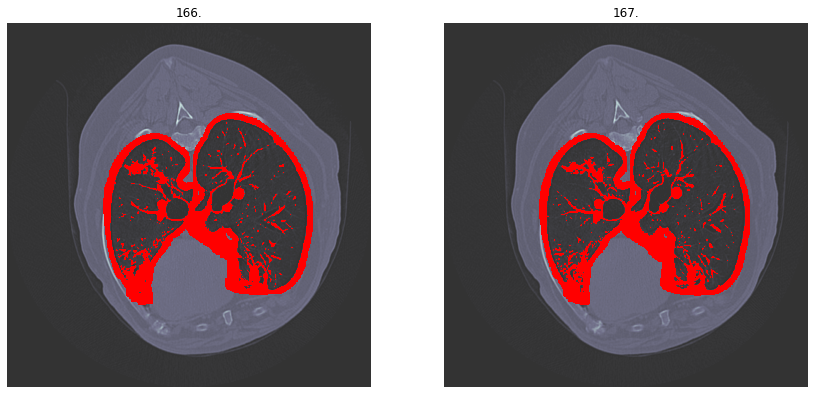

<Figure size 2160x2160 with 0 Axes>

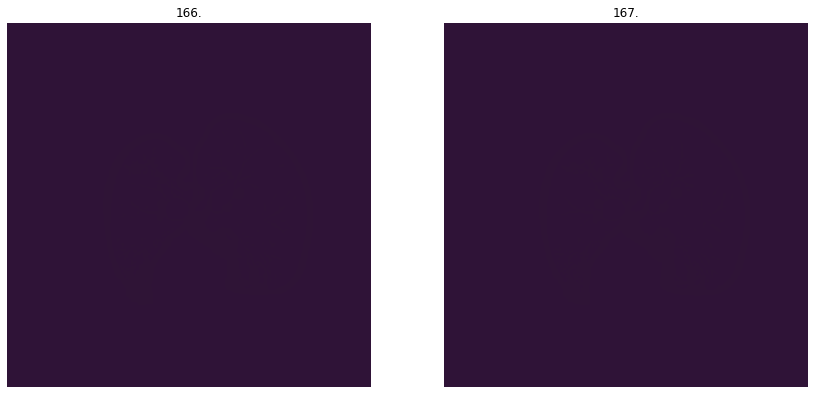

<Figure size 2160x2160 with 0 Axes>

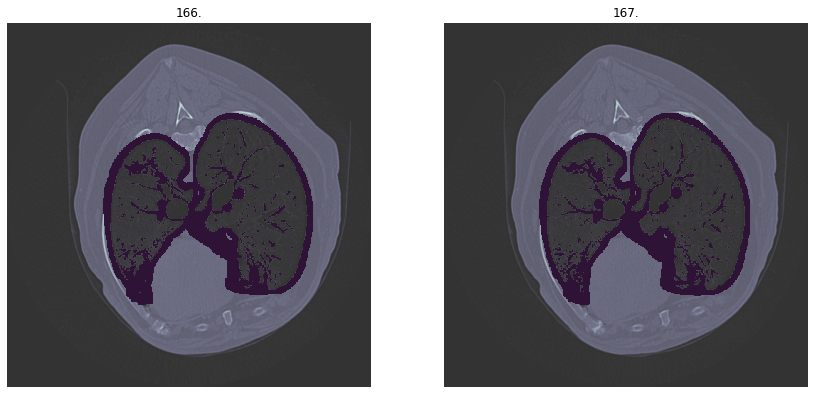

<Figure size 2160x2160 with 0 Axes>

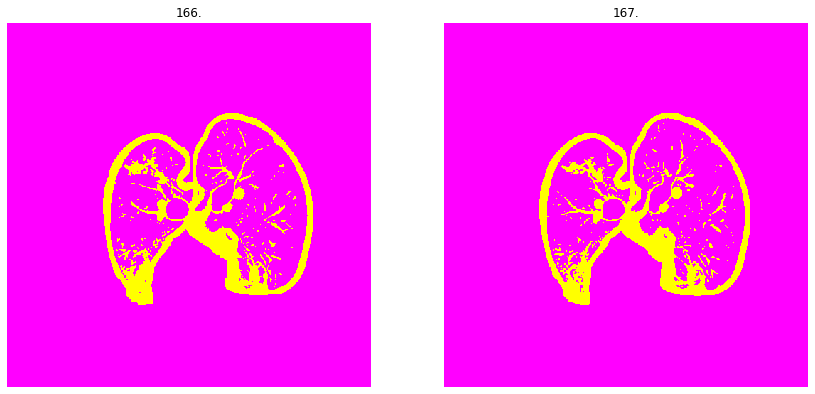

<Figure size 2160x2160 with 0 Axes>

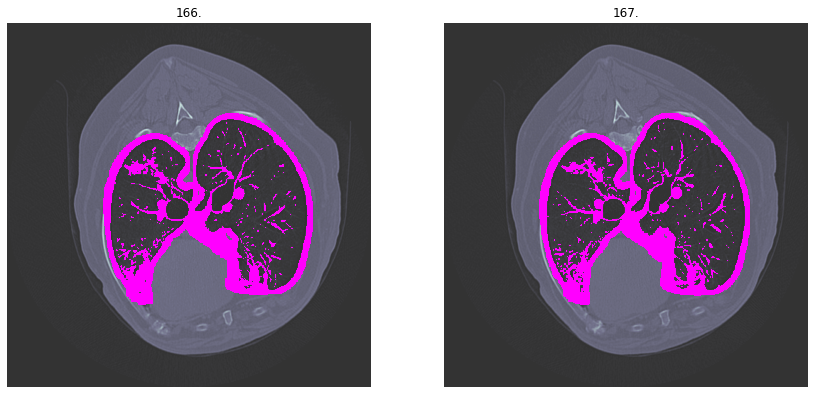

<Figure size 2160x2160 with 0 Axes>

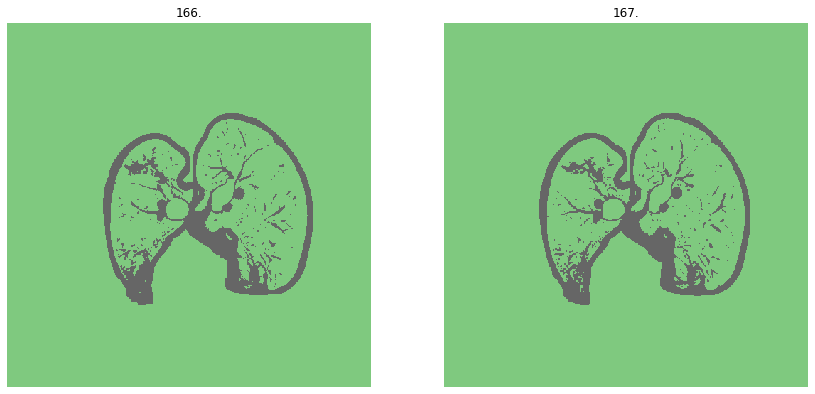

<Figure size 2160x2160 with 0 Axes>

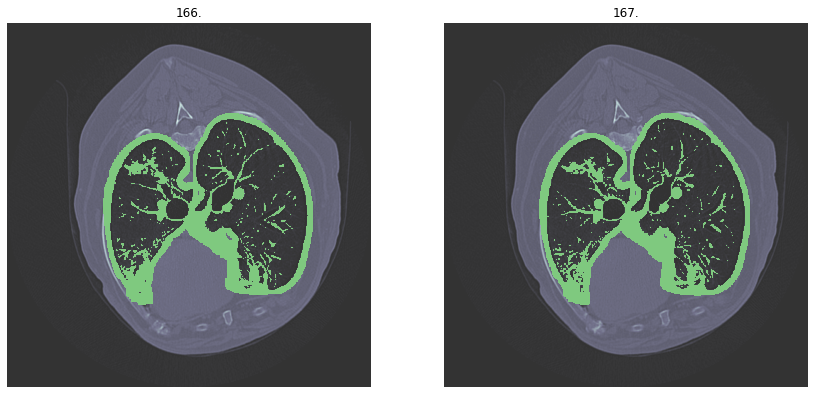

<Figure size 2160x2160 with 0 Axes>

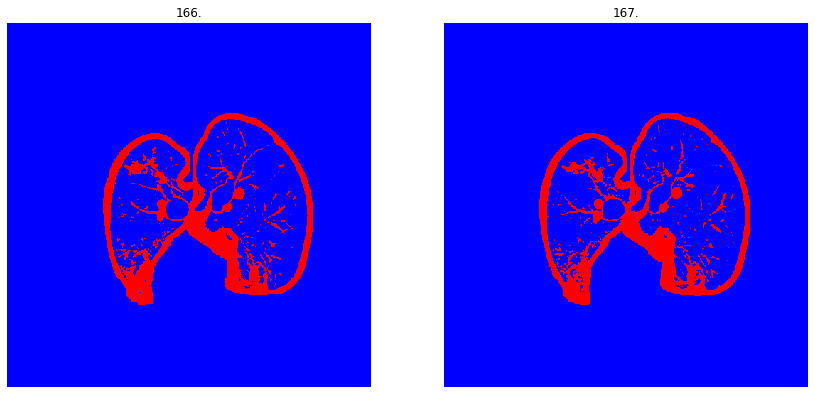

<Figure size 2160x2160 with 0 Axes>

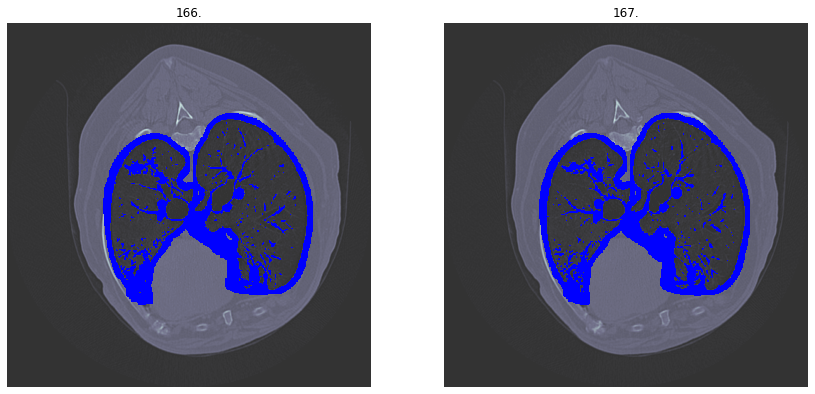

<Figure size 2160x2160 with 0 Axes>

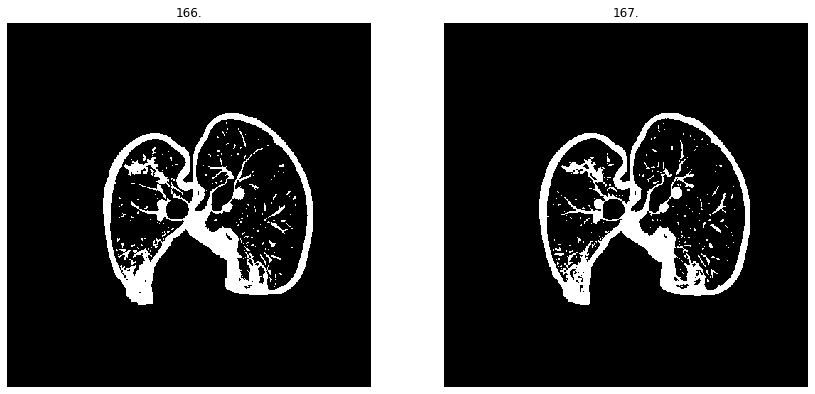

<Figure size 2160x2160 with 0 Axes>

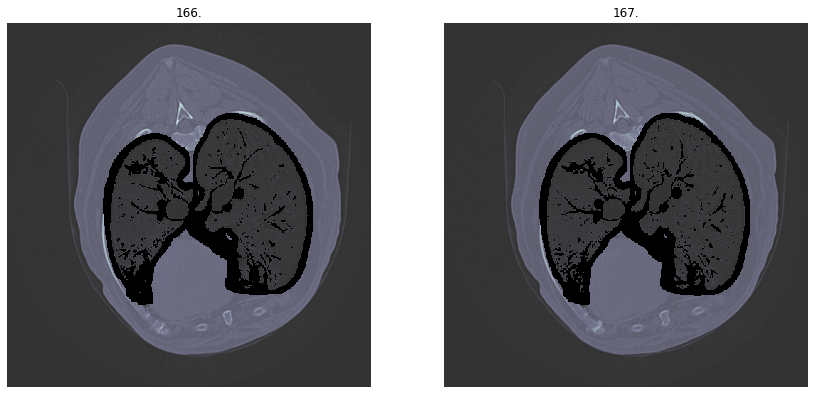

In [46]:
for cmap in featured_cmaps:
    print_CT_layers_segmented(166,168,own_internal_structures,cmap, False)
    print_CT_layers_segmented(166,168,own_internal_structures,cmap, True)


In [48]:
#GIF making:
import imageio
from IPython import display
def make_a_GIF(imgs, GIFNAME):
    imageio.mimsave(f'./{GIFNAME}.gif', imgs, duration=0.1)
    display.Image(f'./{GIFNAME}.gif', format='png')

In [ ]:
make_a_GIF(own_internal_structures,)